# Analysis on ResMaskNet & SVM FER method using Padova Data

## Lib

In [11]:
from feat import Detector
import pandas as pd
import os
import matplotlib.pyplot as plt

## Load Data

In [9]:
# Directory names
video_clips  = 'data/PEDFE_set_clips/'  
video_labels = 'data/Supplemental_Material_T1.csv'
labels = pd.read_csv(video_labels)

## Pandova Analysis

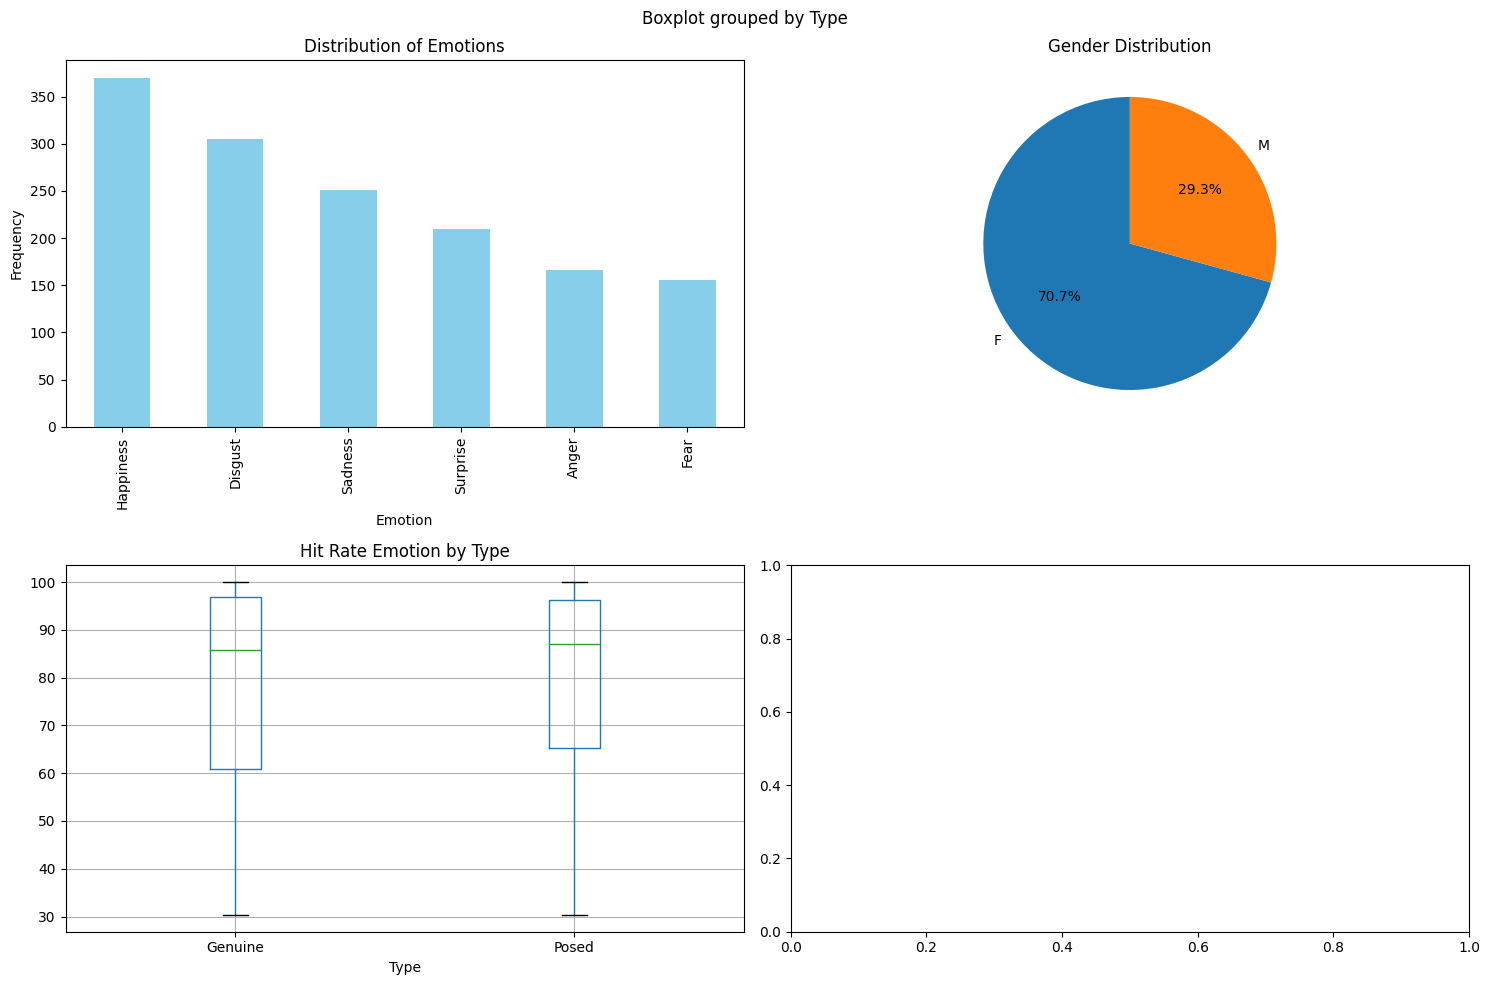

In [19]:
# Load the dataset
df = pd.read_csv('data/Supplemental_Material_T1.csv')

# Set up the matplotlib figure with multiple subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Histogram of Emotions
df['Emotion'].value_counts().plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribution of Emotions')
axes[0, 0].set_xlabel('Emotion')
axes[0, 0].set_ylabel('Frequency')

# Gender Distribution
df['Gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=axes[0, 1])
axes[0, 1].set_title('Gender Distribution')
axes[0, 1].set_ylabel('')

# Hit Rate Emotion by Emotion Type
df.boxplot(column='Hit rate Emotion (%)', by='Type', ax=axes[1, 0])
axes[1, 0].set_title('Hit Rate Emotion by Type')
axes[1, 0].set_xlabel('Type')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## Emotion Classification

In [36]:
detector = Detector(
    face_model="img2pose",
    landmark_model="mobilefacenet",
    au_model='xgb',
    emotion_model="resmasknet",
    facepose_model="img2pose",
    device='cuda' #Use GPU Acceleration
)

In [40]:
# Loop through each entry in the PEDFE_code column
combined_results = pd.DataFrame()
err = []
for PEDFE_code in labels['PEDFE_code']:
    try:
        video_path = os.path.join(video_clips, f'{PEDFE_code}.avi')
        print("\n--------")
        print(f'Processing video: {video_path}')
        # Detect with py-feat
        result = detector.detect_video(video_path=video_path, skip_frames=5, batch_size=35)
        # Calculate mean
        result = result.extract_mean()
        # Append emotion prediction result
        result_emo = result[['mean_anger','mean_disgust','mean_fear','mean_happiness','mean_sadness','mean_surprise','mean_neutral']]
        result_emo = pd.DataFrame({'PEDFE_code': PEDFE_code, **result_emo}) # Insert PDFE_CODE as the first column
        # Save to CSV
        # Append to combined results
        combined_results = pd.concat([combined_results, result_emo], ignore_index=True)
    except:
        err.append(video_path)
combined_results.to_csv("combined_results.csv", index=False)


--------
Processing video: data/PEDFE_set_clips/1_dg_1.avi


100%|██████████| 1/1 [00:05<00:00,  5.59s/it]



--------
Processing video: data/PEDFE_set_clips/1_dg_2.avi


100%|██████████| 1/1 [00:07<00:00,  7.12s/it]



--------
Processing video: data/PEDFE_set_clips/1_dg_3.avi

--------
Processing video: data/PEDFE_set_clips/1_dg_4.avi


100%|██████████| 1/1 [00:03<00:00,  3.75s/it]



--------
Processing video: data/PEDFE_set_clips/1_dg_5.avi


100%|██████████| 1/1 [00:04<00:00,  4.60s/it]



--------
Processing video: data/PEDFE_set_clips/1_dg_6.avi


  0%|          | 0/1 [00:01<?, ?it/s]



--------
Processing video: data/PEDFE_set_clips/1_ds_1.avi


100%|██████████| 1/1 [00:04<00:00,  4.64s/it]



--------
Processing video: data/PEDFE_set_clips/1_ds_2.avi


100%|██████████| 1/1 [00:04<00:00,  4.03s/it]



--------
Processing video: data/PEDFE_set_clips/1_ds_3.avi


  0%|          | 0/1 [00:00<?, ?it/s]

## F1 Score

In [9]:
from sklearn.metrics import f1_score, classification_report
import pandas as pd

predicted_data = pd.read_csv("data/combined_results.csv")
actual_data = pd.read_csv('data/Supplemental_Material_T1.csv')

# emotion to lowercase for comparison
actual_data['Emotion'] = actual_data['Emotion'].str.lower()

# extract highest mean as predicted emotion
predicted_data['predicted_emotion'] = predicted_data.iloc[:, 1:].idxmax(axis=1).str.split('_').str[1]

# Merge actual and predicted data on 'PEDFE_code'
merged_data = pd.merge(actual_data, predicted_data, on='PEDFE_code')

# Select only the specified columns
selected_columns = [
    'PEDFE_code', 'Gender', 'Type', 'Hit rate Emotion (%)', 'Mean_Genuineness',
    'Mean_Intensity', 'mean_anger', 'mean_disgust', 'mean_fear', 'mean_happiness',
    'mean_sadness', 'mean_surprise', 'mean_neutral', 'Emotion', 'predicted_emotion'
]
print("merged_data\n", merged_data[selected_columns].head(2))  # Print merged data with selected columns

# Calculate F1 score for each emotion category
emotion_labels = actual_data['Emotion'].unique()
f1_scores = f1_score(merged_data['Emotion'], merged_data['predicted_emotion'], average=None, labels=emotion_labels)

# Mapping the F1 scores with their corresponding emotions
emotion_f1_scores = dict(zip(emotion_labels, f1_scores))

# Average F1 score across all emotions
average_f1_score = f1_score(merged_data['Emotion'], merged_data['predicted_emotion'], average='macro')

correlation_matrix = merged_data[['Hit rate Emotion (%)', 'Mean_Genuineness', 'Mean_Intensity']].corr()
print(correlation_matrix)

report = classification_report(merged_data['Emotion'], merged_data['predicted_emotion'], labels=merged_data['Emotion'].unique())
print(report)


merged_data
   PEDFE_code Gender     Type  Hit rate Emotion (%)  Mean_Genuineness  \
0     1_dg_1      F  Genuine                 78.79              2.12   
1     1_dg_2      F  Genuine                 54.55              3.00   

   Mean_Intensity  mean_anger  mean_disgust  mean_fear  mean_happiness  \
0            2.94    0.018696      0.521609   0.003493        0.002931   
1            3.52    0.067074      0.277590   0.003294        0.000530   

   mean_sadness  mean_surprise  mean_neutral  Emotion predicted_emotion  
0      0.400101       0.000314      0.052858  disgust           disgust  
1      0.583805       0.000409      0.067298  disgust           sadness  
                      Hit rate Emotion (%)  Mean_Genuineness  Mean_Intensity
Hit rate Emotion (%)              1.000000          0.014555        0.436330
Mean_Genuineness                  0.014555          1.000000        0.184682
Mean_Intensity                    0.436330          0.184682        1.000000
              pre

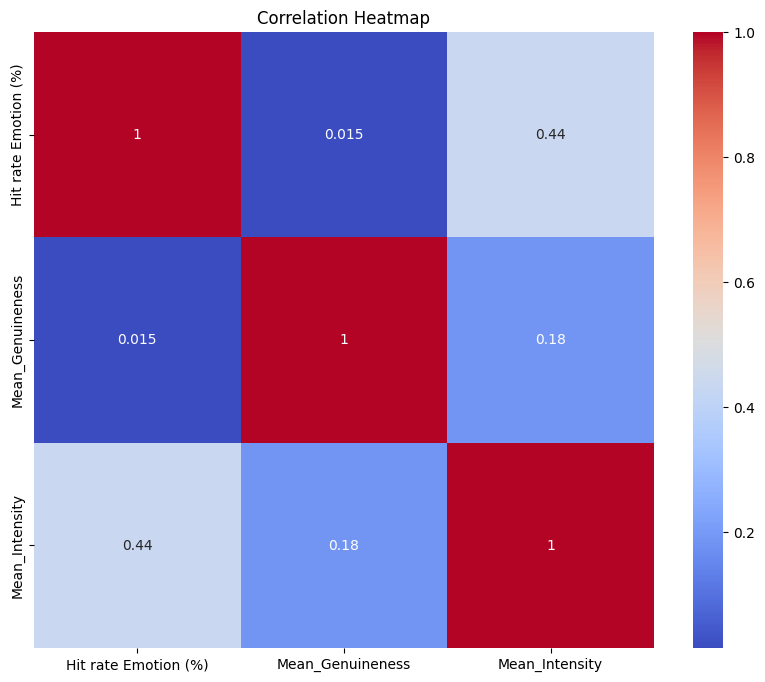

In [12]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()